In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd

from shapely.geometry import Point, Polygon, LineString,MultiLineString

In [2]:
with open(r'nodes_edges_ucla_big_graph.pickle', 'rb') as handle:
    B_matrix_sliced,B_matrix_str_sliced,nodes_coordinates_array = pickle.load(handle)

In [3]:
udf=gpd.read_file(r"ucla_large_centrality_roi.geojson")

blocks=gpd.read_file(r"blocks_epsg4326.geojson")

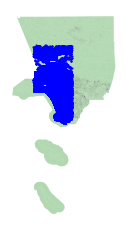

In [4]:
# G=nx.DiGraph()

# for i in range(len(B_matrix_sliced)):
#     oneway=B_matrix_str_sliced[i,2]
    
#     if oneway==None:        
#         G.add_edge(int(B_matrix_sliced[i,0]),int(B_matrix_sliced[i,1]),sect_id=str(B_matrix_str_sliced[i,3]),distance=int(B_matrix_sliced[i,2]),speed=int(B_matrix_sliced[i,3]),weight=B_matrix_sliced[i,4],walk_min=B_matrix_sliced[i,5],name=str(B_matrix_str_sliced[i,0]),roadtype=str(B_matrix_str_sliced[i,1]))
#         G.add_edge(int(B_matrix_sliced[i,1]),int(B_matrix_sliced[i,0]),sect_id=str(B_matrix_str_sliced[i,3]),distance=int(B_matrix_sliced[i,2]),speed=int(B_matrix_sliced[i,3]),weight=B_matrix_sliced[i,4],walk_min=B_matrix_sliced[i,5],name=str(B_matrix_str_sliced[i,0]),roadtype=str(B_matrix_str_sliced[i,1]))
#     elif oneway=="FT":        
#         G.add_edge(int(B_matrix_sliced[i,0]),int(B_matrix_sliced[i,1]),sect_id=str(B_matrix_str_sliced[i,3]),distance=int(B_matrix_sliced[i,2]),speed=int(B_matrix_sliced[i,3]),weight=B_matrix_sliced[i,4],walk_min=B_matrix_sliced[i,5],name=str(B_matrix_str_sliced[i,0]),roadtype=str(B_matrix_str_sliced[i,1]))
#     elif oneway=="TF":        
#         G.add_edge(int(B_matrix_sliced[i,1]),int(B_matrix_sliced[i,0]),sect_id=str(B_matrix_str_sliced[i,3]),distance=int(B_matrix_sliced[i,2]),speed=int(B_matrix_sliced[i,3]),weight=B_matrix_sliced[i,4],walk_min=B_matrix_sliced[i,5],name=str(B_matrix_str_sliced[i,0]),roadtype=str(B_matrix_str_sliced[i,1]))
#     else:
#         print("Error")



# fig,ax=plt.subplots(1)
# blocks.plot(ax=ax,color="green",alpha=0.3)
# udf.plot(ax=ax,color="gray",linestyle="--")
# nx.draw(G.to_undirected(),pos=nodes_coordinates_array[:,0:2],node_size=1,node_color="blue", with_labels = False)

In [8]:
udf.shape

(238422, 98)

In [9]:
blocks.shape

(91626, 16)

# 01 Block Determination

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
from shapely import Point
from shapely.ops import nearest_points
from rtree import index

# Import and subset block data
blocknumbers = np.array(blocks["GEOID20"],dtype=str)
blockboundaries = np.array(blocks["geometry"])

Hillside_NodeCoordinate = nodes_coordinates_array[:,0:2]

# Check if blockboundaries and blocknumbers are the same length
if len(blockboundaries) != len(blocknumbers):
    print("Error: Length of blockboundaries and blocknumbers do not match")

# Create an R-tree index
idx = index.Index()
for i, boundary in enumerate(blockboundaries):
    idx.insert(i, boundary.bounds)

# Initialize empty lists to store node and block information
Node_Block = []
Unidentified_Nodes = []

# Identify nodes that are in a block using R-tree
for i in range(len(Hillside_NodeCoordinate)):
    coord = Hillside_NodeCoordinate[i]
    possible_blocks = list(idx.intersection((coord[0], coord[1], coord[0], coord[1])))
    for block_idx in possible_blocks:
        if blockboundaries[block_idx].contains(Point(coord[0], coord[1])):
            Node_Block.append([i, blocknumbers[block_idx], blockboundaries[block_idx]])

Identified_Nodes = np.array([row[0] for row in Node_Block])
total_nodes_identified = len(Node_Block)
total_nodes_out_of_bounds = len(Hillside_NodeCoordinate) - total_nodes_identified
extracted_blocknumbers = np.array([item[1] for item in Node_Block])
unique_blocknumbers = np.unique(extracted_blocknumbers)
unique_blocknumbers_count = len(unique_blocknumbers)

print("Total nodes identified: " + str(total_nodes_identified), "\nNodes out of bounds: " + str(total_nodes_out_of_bounds), "\nUnique blocknumbers: " + str(unique_blocknumbers_count))

# Make a list with the first element in Node_Block
Identified_Nodes_Index = [item[0] for item in Node_Block]

# Identify nodes that are not in any block
for i in range(len(Hillside_NodeCoordinate)):
    if i not in Identified_Nodes:
        Unidentified_Nodes.append(i)

print('Nodes without block placement: ' + str(Unidentified_Nodes))

# Identify the closest block for each node that is not in any block
for i in Unidentified_Nodes:
    closest_block = min(blockboundaries, key=lambda x: x.distance(Point(Hillside_NodeCoordinate[i][0], Hillside_NodeCoordinate[i][1])))
    closest_block_idx = np.where(blockboundaries == closest_block)
    closest_block_number = blocknumbers[closest_block_idx]
    print('Node coordinate ' + str(i) + ' with coordinates ' + str(Hillside_NodeCoordinate[i]) + ' is closest to block ' + str(closest_block_number))
    Node_Block.insert(i, [i, closest_block_number, closest_block])

# Check if all nodes have been identified
total_nodes_identified = len(Node_Block)

print("Total nodes identified: " + str(total_nodes_identified))

# Save Node_Block as a pickle file
with open(r'intermediate_files/Node_Block.pkl', 'wb') as f:
    pickle.dump(Node_Block, f)

In [22]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
from shapely import Point
from shapely.ops import nearest_points
from rtree import index
from tqdm import tqdm

# Import and subset block data
blocknumbers = np.array(blocks["GEOID20"],dtype=str)
blockboundaries = np.array(blocks["geometry"])

Hillside_NodeCoordinate = nodes_coordinates_array[:,0:2]

# Create a dictionary mapping block boundaries to their indices
block_to_index = {boundary: i for i, boundary in enumerate(blockboundaries)}

# Use a set to keep track of identified nodes
identified_nodes = set()

# Use a DataFrame for Node_Block
Node_Block = pd.DataFrame(columns=['Node', 'BlockNumber', 'BlockBoundary'])

# Create an R-tree index
idx = index.Index()
for i, boundary in enumerate(blockboundaries):
    idx.insert(i, boundary.bounds)

# Identify nodes that are in a block using R-tree
for i in tqdm(range(len(Hillside_NodeCoordinate)), desc="Filtering nodes"):
    coord = Hillside_NodeCoordinate[i]
    possible_blocks_indices = list(idx.intersection((coord[0], coord[1], coord[0], coord[1])))
    for block_index in possible_blocks_indices:
        block = blockboundaries[block_index]
        if block.contains(Point(coord[0], coord[1])):
            new_row = pd.DataFrame({'Node': [i], 'BlockNumber': [blocknumbers[block_index]], 'BlockBoundary': [block]})
            Node_Block = pd.concat([Node_Block, new_row], ignore_index=True)
            identified_nodes.add(i)

# Identify nodes that are not in any block
unidentified_nodes = set(range(len(Hillside_NodeCoordinate))) - identified_nodes

# Identify the closest block for each node that is not in any block
for i in tqdm(unidentified_nodes, desc="Identifying closest blocks"):
    closest_block = min(blockboundaries, key=lambda x: x.distance(Point(Hillside_NodeCoordinate[i][0], Hillside_NodeCoordinate[i][1])))
    new_row = pd.DataFrame({'Node': [i], 'BlockNumber': [blocknumbers[block_to_index[closest_block]]], 'BlockBoundary': [closest_block]})
    Node_Block = pd.concat([Node_Block, new_row], ignore_index=True)

# Total nodes identified
total_nodes_identified = len(Node_Block)
print("Total nodes identified: " + str(total_nodes_identified))

# Save Node_Block as a pickle file
with open(r'intermediate_files/Node_Block.pkl', 'wb') as f:
    pickle.dump(Node_Block, f)


Identifying closest blocks: 100%|██████████| 67/67 [06:30<00:00,  5.82s/it]


Total nodes identified: 180087


In [23]:
# import Node_Block.pkl

with open(r'intermediate_files/Node_Block.pkl', 'rb') as f:
    Node_Block = pickle.load(f)



,Node,BlockNumber,BlockBoundary
0,0,060378002062007,"MULTIPOLYGON (((-118.68372 34.164316, -118.683..."
1,1,060379201061055,"MULTIPOLYGON (((-118.681741 34.444332, -118.68..."
2,2,060378005041027,"MULTIPOLYGON (((-118.685613 34.036776, -118.68..."
3,3,060378002021012,"MULTIPOLYGON (((-118.68486 34.084816, -118.684..."
4,4,060379201061079,"MULTIPOLYGON (((-118.707669 34.436242, -118.70..."
...,...,...,...
180082,162810,060371132351008,"MULTIPOLYGON (((-118.645234 34.238084, -118.64..."
180083,3196,060371132351004,"MULTIPOLYGON (((-118.636906 34.2404, -118.6363..."
180084,162813,060371132351007,"MULTIPOLYGON (((-118.643995 34.240384, -118.64..."
180085,162814,060371132351007,"MULTIPOLYGON (((-118.643995 34.240384, -118.64..."
